# Udacity Self-Driving Car Engineer Nanodegree Program
## Vehicle Detection Project
---
The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

### Import Statements

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML, display
import numpy as np
import pickle
import cv2
import glob
import time
import math
import tabulate

%matplotlib inline

print('---')

---


### Helper Functions

In [2]:
def display_and_save(images, titles=False, filename=False, gray=False):
    number_of_images = len(images)
    rows = math.ceil(number_of_images / 2)
    fig, axs = plt.subplots(rows, 2, figsize=(7, 3 * rows))
    fig.subplots_adjust(hspace=.2, wspace=.2)
    axs = axs.ravel()

    for i in range(2 * rows):
        axs[i].axis('off')

    for index, image in enumerate(images):
        if gray == True:
            axs[index].imshow(image, cmap='gray')
        else:
            axs[index].imshow(image)
        if titles:
            axs[index].set_title(titles[index], fontsize=15)

    if filename:
        fig.savefig("./assets/report/" + filename)
        
print("---")

---


### Load Training Data Set

In [3]:
car_images = glob.glob('./training_data/vehicles/**/*.png')
total_car_images = len(car_images)
non_car_images = glob.glob('./training_data/non-vehicles/**/*.png')
total_non_car_images = len(non_car_images)

print("There are {} car images".format(total_car_images))
print("There are {} non-car images".format(total_non_car_images))
print("---")

There are 3425 car images
There are 3900 non-car images
---


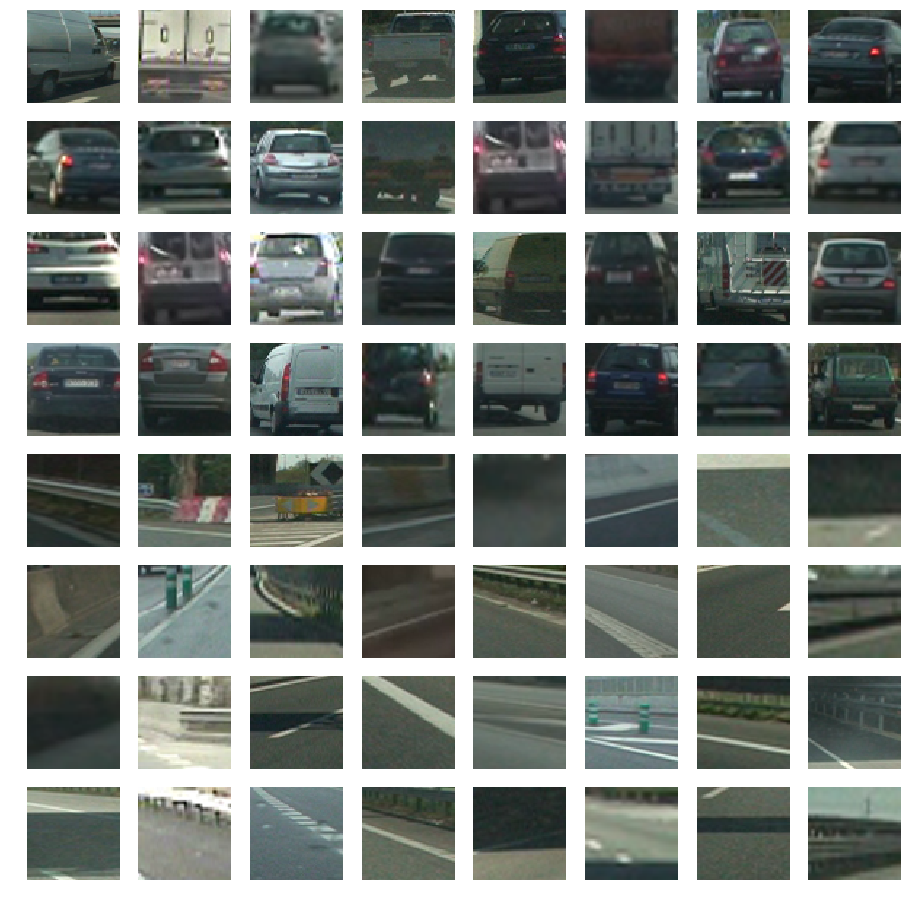

In [4]:
figure, axis = plt.subplots(8, 8, figsize=(16, 16))
figure.subplots_adjust(hspace=0.2, wspace=0.001)
axis = axis.ravel()

# Iterate through the car images
for index in range(32):
    image_index = np.random.randint(0, total_car_images)
    image = cv2.imread(car_images[image_index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axis[index].axis('off')
    axis[index].imshow(image)

# Iterate through non-car images
for index in range(32, 64):
    image_index = np.random.randint(0, total_car_images)
    image = cv2.imread(non_car_images[image_index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axis[index].axis('off')
    axis[index].imshow(image)
    

### Convert to HOG (Histogram of Oriented Gradients)


Visulize HOG Images


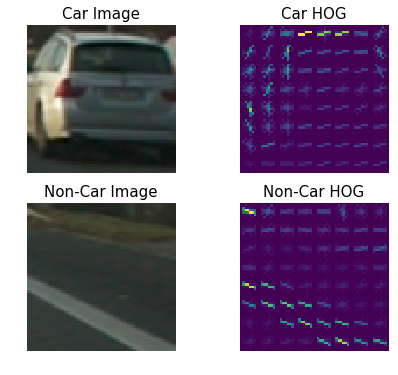

In [5]:
# if visulise = True, returns features, hog_image
# else returns features only
def convert_to_hog(image, orientations, pixel_per_cell, cell_per_block, visualise=False, feature_vector=True):
    return hog(image, orientations=orientations,
               pixels_per_cell=(pixel_per_cell, pixel_per_cell),
               cells_per_block=(cell_per_block, cell_per_block),
               transform_sqrt=False, visualise=visualise,
               feature_vector=feature_vector)

print("Visulize HOG Images")

output_images = []
output_titles = []
car_image = mpimg.imread(car_images[50])
_, car_destination = convert_to_hog(car_image[:, :, 2], 9, 8, 8, visualise=True, feature_vector=True)
non_car_image = mpimg.imread(non_car_images[50])
_, non_car_destination = convert_to_hog(non_car_image[:, :, 2], 9, 8, 8, visualise=True, feature_vector=True)

# Visualization
output_images.append(car_image)
output_titles.append("Car Image")
output_images.append(car_destination)
output_titles.append("Car HOG")
output_images.append(non_car_image)
output_titles.append("Non-Car Image")
output_images.append(non_car_destination)
output_titles.append("Non-Car HOG")
display_and_save(output_images, output_titles, filename="hog.jpg")

In [6]:

# Define a function to extract features from a list of image locations
# This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract
# flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
# to be used together for classification
def extract_features(imgs, cspace='RGB', orientations=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call convert_to_hog() with visualise=False, feature_vector=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(convert_to_hog(feature_image[:,:,channel], orientations, pix_per_cell, cell_per_block, visualise=False, feature_vector=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = convert_to_hog(feature_image[:,:,hog_channel], orientations, pix_per_cell, cell_per_block, visualise=False, feature_vector=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

print('---')

---


### Explore HOG parameters
- This cell takes up to 25 min to run
- Should be commented out if not exploring with HOG parameters

In [11]:
table = [];
configuration = ["Run #", "Colorspace", "Orientations", "Pixels Per Cell", "Cells Per Block", "HOG Channel", "Extraction Time", "Classifier Type", "Accuracy", "Training Time"]
table.append(configuration)
# Constants
orientations = 11
pix_per_cell = 16
cell_per_block = 2
run_number = 1
# Variable Factors
for colorspace in ['RGB', 'HSV', 'LUV','HLS', 'YUV', 'YCrCb']:
    for hog_channel in [0, 1, 2, "ALL"]:
        # feature extraction
        t1 = time.time()
        car_features = extract_features(car_images, cspace=colorspace, orientations=orientations, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
        non_car_features = extract_features(non_car_images, cspace=colorspace, orientations=orientations, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
        t2 = time.time()
        # Training
        X = np.vstack((car_features, non_car_features)).astype(np.float64)  
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

        # Split up data into randomized training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=np.random.randint(0, 999))

        # Use a SVM Classifier (Support Vector Machine)
        svc = LinearSVC()
        t1 = time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        duration = round(t2 - t1, 1)
        accuracy = round(svc.score(X_test, y_test) * 100, 1)
        
        # record data
        configuration = [run_number, colorspace, orientations, pix_per_cell, cell_per_block, hog_channel, round(t2-t1, 1), "Linear SVC", accuracy, duration]
        table.append(configuration)
        run_number += 1
        
        

display(HTML(tabulate.tabulate(table, tablefmt='html')))

Run #,Colorspace,Orientations,Pixels Per Cell,Cells Per Block,HOG Channel,Extraction Time,Classifier Type,Accuracy,Training Time
1,RGB,11,16,2,0,0.2,Linear SVC,95.4,0.2
2,RGB,11,16,2,1,0.1,Linear SVC,95.5,0.1
3,RGB,11,16,2,2,0.2,Linear SVC,94.7,0.2
4,RGB,11,16,2,ALL,0.8,Linear SVC,96.7,0.8
5,HSV,11,16,2,0,0.3,Linear SVC,90.6,0.3
6,HSV,11,16,2,1,0.2,Linear SVC,89.0,0.2
7,HSV,11,16,2,2,0.2,Linear SVC,94.9,0.2
8,HSV,11,16,2,ALL,0.4,Linear SVC,97.8,0.4
9,LUV,11,16,2,0,0.2,Linear SVC,94.9,0.2
10,LUV,11,16,2,1,0.2,Linear SVC,90.6,0.2


### Extract HOG parameters

In [10]:
# Constants
orientations = 11
pix_per_cell = 16
cell_per_block = 2
colorspace = "YUV" # OR RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = 'ALL' # OR 0, 1, 2, or "ALL"
# Variable Factors
t1 = time.time()
car_features = extract_features(car_images, cspace=colorspace, orientations=orientations, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
non_car_features = extract_features(non_car_images, cspace=colorspace, orientations=orientations, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
t2 = time.time()

print('It takes {} seconds to run'.format(round(t2 - t1), 2))

It takes 0.5 seconds to train SVC.
Classifier achieved 97.0% accuracy.


### Classifier Training

In [ ]:
# Define the labels vector
X = np.vstack((car_features, non_car_features)).astype(np.float64)  
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=np.random.randint(0, 999))

# Use a SVM Classifier (Support Vector Machine)
svc = LinearSVC()
t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print("It takes {} seconds to train SVC.".format(round(t2 - t1, 1)))
print("Classifier achieved {}% accuracy.".format(round(svc.score(X_test, y_test) * 100, 1)))

### Car Finding (Pre-pipeline)

In [12]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            ################ ONLY FOR BIN_SPATIAL AND COLOR_HIST ################

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            
            ######################################################################
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles
    
print('---')

---
